In [1]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND = tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
# import networkx as nx # draw graph vertex & edge
# import pydub # audio
# from numpy.fft import fft, ifft, irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.callbacks import History
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

# for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers import Reshape
# for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K
from keras import metrics

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

import matplotlib.image as mpimg # import image file
from PIL import Image, ImageEnhance # image processing

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [35]:
split_line_input = Input(shape = (None, None, 1), name = 'split_line_input')
# z = Lambda(lambda v: 2 * v - K.ones_like(v), name = 'split_line_input_setting_bios')(split_line_input)
layer = Conv2D(3, (8, 8), padding = 'same', trainable = False, name = 'split_line_c1')
z = layer(split_line_input)

### setting weights
w = layer.get_weights()
w[0][:, :, 0, 0] = 0
w[0][0, :, 0, 0] = 8
w[0][:, :, 0, 1] = 0
w[0][-1:, :, 0, 1] = 8
w[0][:, :, 0, 2] = 1
w[1] = np.zeros_like(w[1])
layer.set_weights(w)

split_line_Lambda = Lambda(lambda v: 
                           K.concatenate([v[:, :, :, 0:1] - v[:, :, :, 2:3], v[:, :, :, 1:2] - v[:, :, :, 2:3]], 
                                         axis = -1), 
                           name = 'split_line_Lambda')(z)
z = Activation('relu', name = 'split_line_relu')(split_line_Lambda)
split_line_model = Model(split_line_input, z, name = 'split_line_model')
print(split_line_model.summary())

def crop_array_image(img, *rects):
    y = img.shape[0]
    x = img.shape[1]
    startx, starty, cropx, cropy = rects
    endx = min(startx + cropx, x)
    endy = min(starty + cropy, y)
    return img[starty:endy, startx:endx]

def increase_contrast_function(x, s = 0.2, e = 0.8):
    max_x = np.max(x.reshape(-1))
    min_x = np.min(x.reshape(-1))
    assert max_x - min_x != 0
    x = (x - min_x) / (max_x - min_x)
    def normalized_increase_contrast_function(x):
        if x < s:
            return 0.
        if x > e:
            return 1.
        x -= s
        x *= e - s
        return -2 * x**3 + 3 * x**2
    x = np.vectorize(normalized_increase_contrast_function)(x)
    return x * (max_x - min_x) + min_x

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
split_line_input (InputLayer (None, None, None, 1)     0         
_________________________________________________________________
split_line_c1 (Conv2D)       (None, None, None, 3)     195       
_________________________________________________________________
split_line_Lambda (Lambda)   (None, None, None, 2)     0         
_________________________________________________________________
split_line_relu (Activation) (None, None, None, 2)     0         
Total params: 195
Trainable params: 0
Non-trainable params: 195
_________________________________________________________________
None


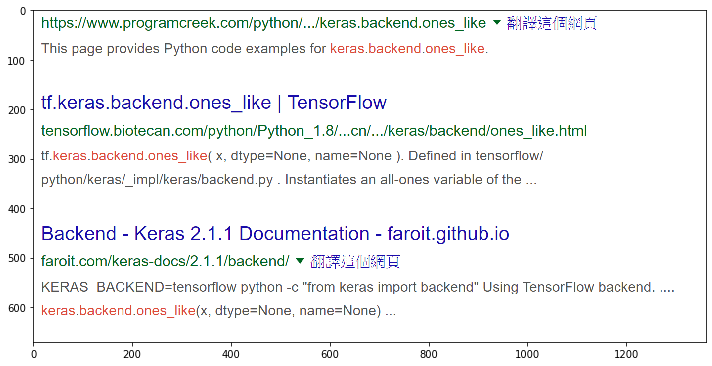

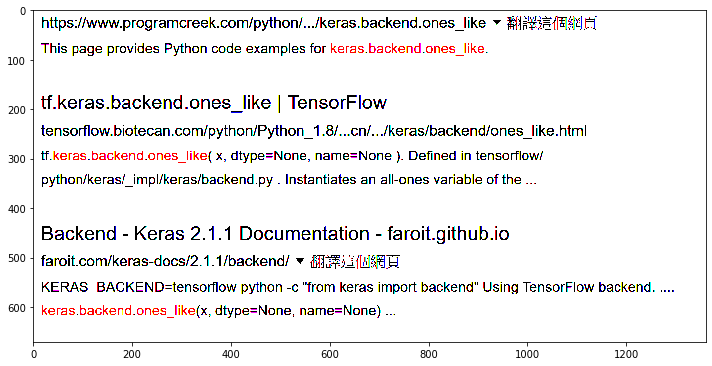

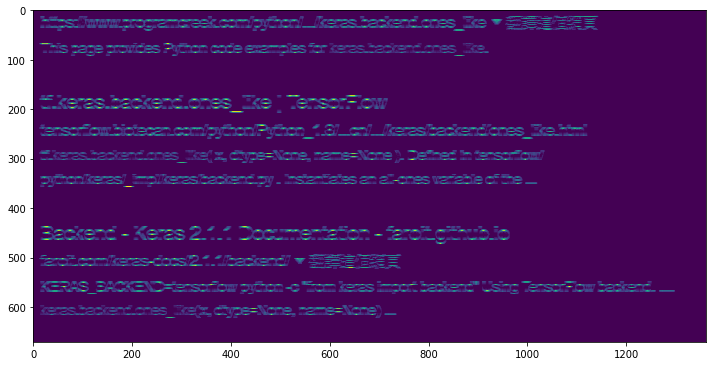

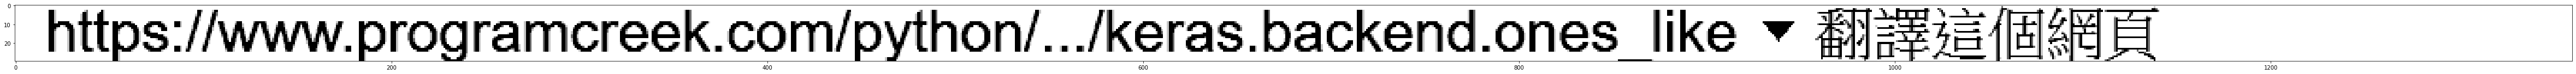

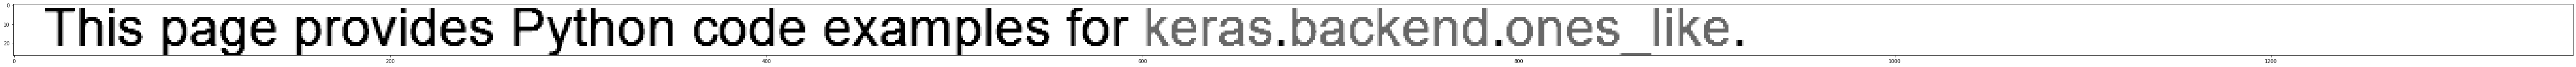

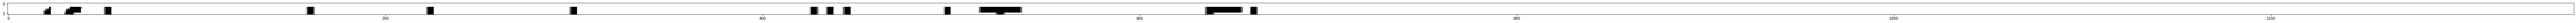

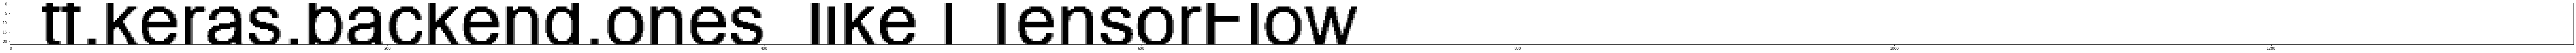

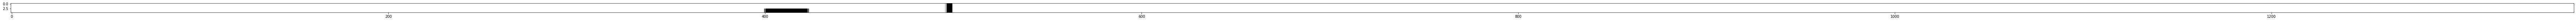

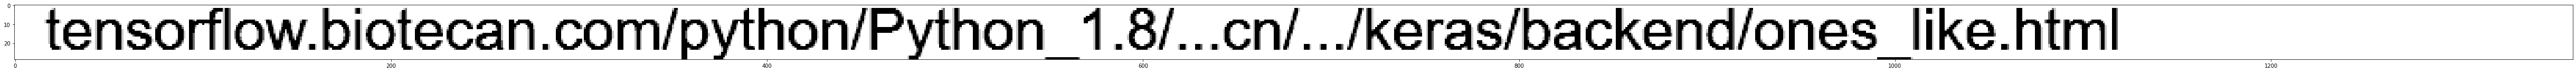

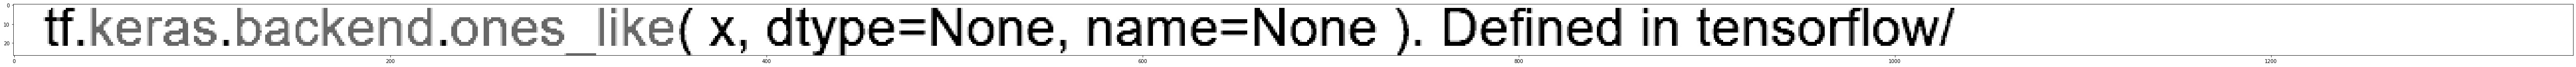

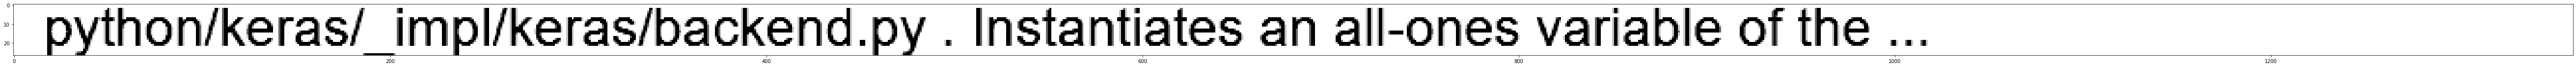

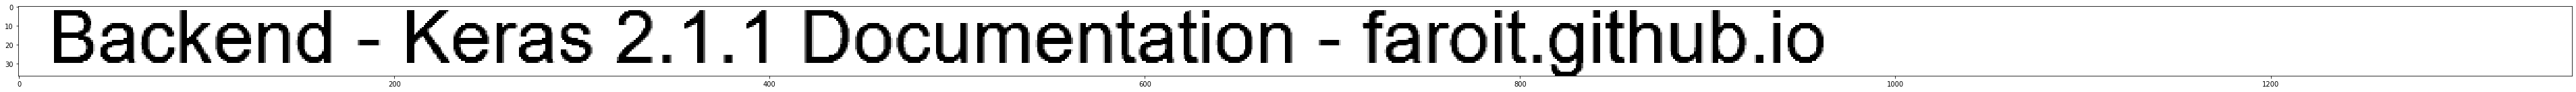

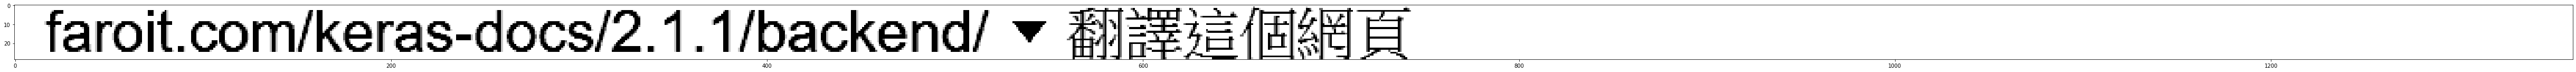

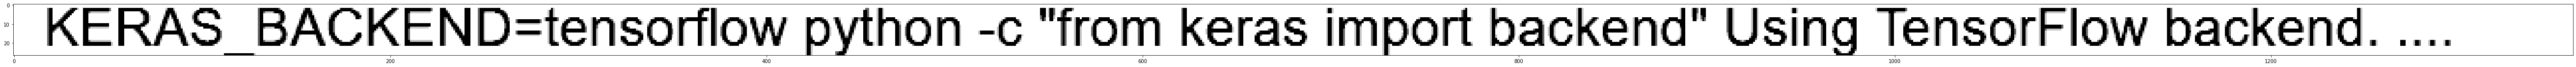

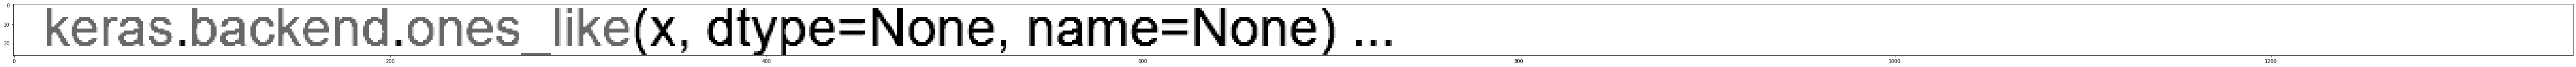

In [56]:
# img_png_0 = mpimg.imread("image_test/line_test.png")
# img_png_0 = mpimg.imread("image_test/line_test_1.png")
# img_png_0 = mpimg.imread("image_test/line_test_2.png")
img_png_0 = mpimg.imread("image_test/line_test_3.png")
# img_png_0 = mpimg.imread("image_test/line_test_4.png")
height, width , _ = img_png_0.shape
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_png_0, interpolation='nearest')
plt.tight_layout()

####### increase contrast #######
# img_png = np.vectorize(increase_contrast_function)(img_png_0)
img_png = increase_contrast_function(img_png_0)
img_png = increase_contrast_function(img_png)
# img_png = img_png[:, 150:250]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_png, interpolation='nearest')
plt.tight_layout()
img_png = np.average(img_png, axis = 2) # transform to only 1 chennel
img_png = 1 - img_png
# img_png = img_png * 2 - 1

predicts = split_line_model.predict(img_png.reshape(1, *(img_png.shape), 1))
# print(predicts[0].shape)
# A = np.average(predicts[0, :, :, 0:2], axis = 2)
A = np.zeros(predicts[0].shape[0:2])
A[0:-3, :] += predicts[0][3:, :, 0]
A[3:, :] += predicts[0][0:-3, :, 1]

# A = increase_contrast_function(A, s = 0.1, e = 0.99)
# A = increase_contrast_function(A, s = 0.01, e = 0.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(A, interpolation='nearest')
plt.tight_layout()

# B = np.average(A, axis = 1)
B = np.max(A, axis = 1)
B = np.array([1. if B[i] - np.min(B.reshape(-1)) > (np.max(B.reshape(-1)) - np.min(B.reshape(-1))) * 0.1 else 0. 
              for i in range(len(B))])
go_up_list = [0 for i in range(1) if B[0] > 0.5] + [i for i in range(len(B)-1) if B[i + 1] - B[i] > 0.5]
if B[-1] > 0.5:
    go_up_list.pop(-1)
go_down_list = [i for i in range(len(B)-1) if B[i] - B[i + 1] > 0.5]
assert len(go_up_list) == len(go_down_list)
varlist = go_up_list + go_down_list
varlist.sort()

####### analyzing rectangles #######
# if varlist[0] < height * 0.01:
#     varlist.pop(0)
# if len(varlist) % 2 == 1:
#     varlist.pop(-1)
rectlist = [[0, varlist[2 * i], width, varlist[2 * i + 1] - varlist[2 * i]] for i in range(len(varlist) // 2)]

line_list = []
line_list_normalize = []
line_list_normalize_ratio = [] # line_list_normalize_ratio[.] * line_list_normalize[.] == line_list[.]
new_line_hh = 30
assert len(rectlist) !=0
for rect in rectlist:
#     C = (crop_array_image(np.array([img_png] * 3).transpose(1, 2, 0), *rect) * 255.).astype(np.uint8)
    C = crop_array_image(img_png, *rect)
    line_list.append(C)

#     C_PIL = Image.fromarray(C)
#     ww, hh = C_PIL.size
#     new_line_ww = new_line_hh * ww // hh
#     C_PIL = C_PIL.resize((new_line_ww, new_line_hh), Image.ANTIALIAS) # Not maintain the ratio
#     # C.thumbnail((1000, 1000), Image.ANTIALIAS) # maintain the ratio
#     C = np.array(C_PIL)
#     line_list_normalize.append(C)
#     line_list_normalize_ratio.append(hh / new_line_hh)
#     # mpimg.imsave("image_test/line_test_line.png", C)

    fig, ax = plt.subplots(figsize=(100, 2))
    ax.imshow(C, interpolation='nearest', cmap='Greys')
    plt.tight_layout()

In [ ]:
#### # %matplotlib inline
# %matplotlib widget
# from matplotlib.widgets import Cursor, Button
# from IPython.display import clear_output

# i = 1
# C = (crop_array_image(np.array([img_png] * 3).transpose(1, 2, 0), *rectlist[i]) * 255).astype(np.uint8)
# fig, ax = plt.subplots(figsize=(10, 1))
# ax.imshow(C)

# xs = []

# cursor = Cursor(ax,
#                 horizOn = False, # Controls the visibility of the horizontal line
#                 vertOn = True, # Controls the visibility of the vertical line
#                 color = 'green',
#                 linewidth=2.0
#                )
# def onclick(event):
#     # clear_output()
#     if event.key == 'x':
#         print("Yo")
#     global xs
#     x1, _1 = event.xdata, event.ydata
#     xs.append(x1)
#     plt.vlines(x1, 0, C.shape[0], colors = "r")
# fig.canvas.mpl_connect('button_press_event', onclick);
# # plt.tight_layout()
# # plt.show()